In [83]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [84]:
results_dir = 'results/'

In [85]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [86]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [87]:
os.listdir(results_dir)

['annotation.csv',
 'chimpDE',
 'chimp_de.pkl',
 'expression.csv',
 'humanDE',
 'human_de.pkl',
 'macaqueDE',
 'macaque_de.pkl']

## Load files

### Load pseudobulk files

In [88]:
pb_dir_path = '../data/pseudobulks/'

In [89]:
os.listdir('../data/pseudobulks/')

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'pb_age.h5ad',
 'pb_age_sample_norm.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [90]:
adata_pb= sc.read_h5ad(pb_dir_path + 'pb_mammals.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 94 × 14963
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [91]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)

normalizing counts per cell
    finished (0:00:00)


### DE results

In [92]:
os.listdir(results_dir + 'humanDE')

['degenes_L1.csv',
 'degenes_L2.csv',
 'degenes_L3.csv',
 'degenes_L4.csv',
 'degenes_L5.csv',
 'degenes_L6.csv',
 'degenes_WM.csv']

In [93]:
human_de = {layer:pd.read_csv(results_dir + f'humanDE/degenes_{layer}.csv', index_col=0) for layer in layers}
chimp_de = {layer:pd.read_csv(results_dir + f'chimpDE/degenes_{layer}.csv', index_col=0) for layer in layers}
macaque_de = {layer:pd.read_csv(results_dir + f'macaqueDE/degenes_{layer}.csv', index_col=0) for layer in layers}

# Explore the results

## Add multiple-test correction

In [94]:
from statsmodels.stats.multitest import multipletests

def multipletest_correction(dict_with_df):
    for layer, df in dict_with_df.items():
        mult_test = multipletests(df['PValue'], method='fdr_bh')
        df['p_val_adj'] = mult_test[1]

multipletest_correction(human_de)
multipletest_correction(chimp_de)
multipletest_correction(macaque_de)

human_de['L1'].head()

logFC    logCPM         F    PValue  p_val_adj
A1BG  -0.469291  8.707962  5.461037  0.024055   0.102840
AAAS   0.044950  8.415859  0.096263  0.758256   0.897767
AACS  -0.197358  8.537271  4.923438  0.030589   0.121801
AADAT  0.161245  8.534666  3.247336  0.077524   0.236195
AAGAB -0.214563  8.468644  3.037362  0.088496   0.259084

In [95]:
import pickle

with open('results/human_de.pkl', 'wb') as f:
    pickle.dump(human_de, f)

with open('results/chimp_de.pkl', 'wb') as f:
    pickle.dump(chimp_de, f)

with open('results/macaque_de.pkl', 'wb') as f:
    pickle.dump(macaque_de, f)

## Load files

In [96]:
import pickle

with open("results/human_de.pkl", "rb") as file:
    human_de = pickle.load(file)

with open("results/chimp_de.pkl", "rb") as file:
    chimp_de = pickle.load(file)

with open("results/macaque_de.pkl", "rb") as file:
    macaque_de = pickle.load(file)

## Summary for each comparison

In [97]:
def summary_de(de_dict):
    summary_dict = dict()
    for layer, df in de_dict.items():
        up_reg = df[(df.p_val_adj < 0.05) & (df.logFC > 0)].shape[0]
        down_reg = df[(df.p_val_adj < 0.05) & (df.logFC < 0)].shape[0]
        not_sign = df.shape[0] - up_reg - down_reg
        summary_dict[layer] = [up_reg, not_sign, down_reg]
    summary_df = pd.DataFrame(summary_dict, index=['up_reg', 'not_sign', 'down_reg'])
    return summary_df

In [98]:
print("Summary for human")
summary_de(human_de)

Summary for human


L1    L2    L3    L4    L5    L6     WM
up_reg     919   875   809   739   950   642    158
not_sign  8658  8892  9298  9334  9018  9527  10367
down_reg   983   793   453   487   592   391     35

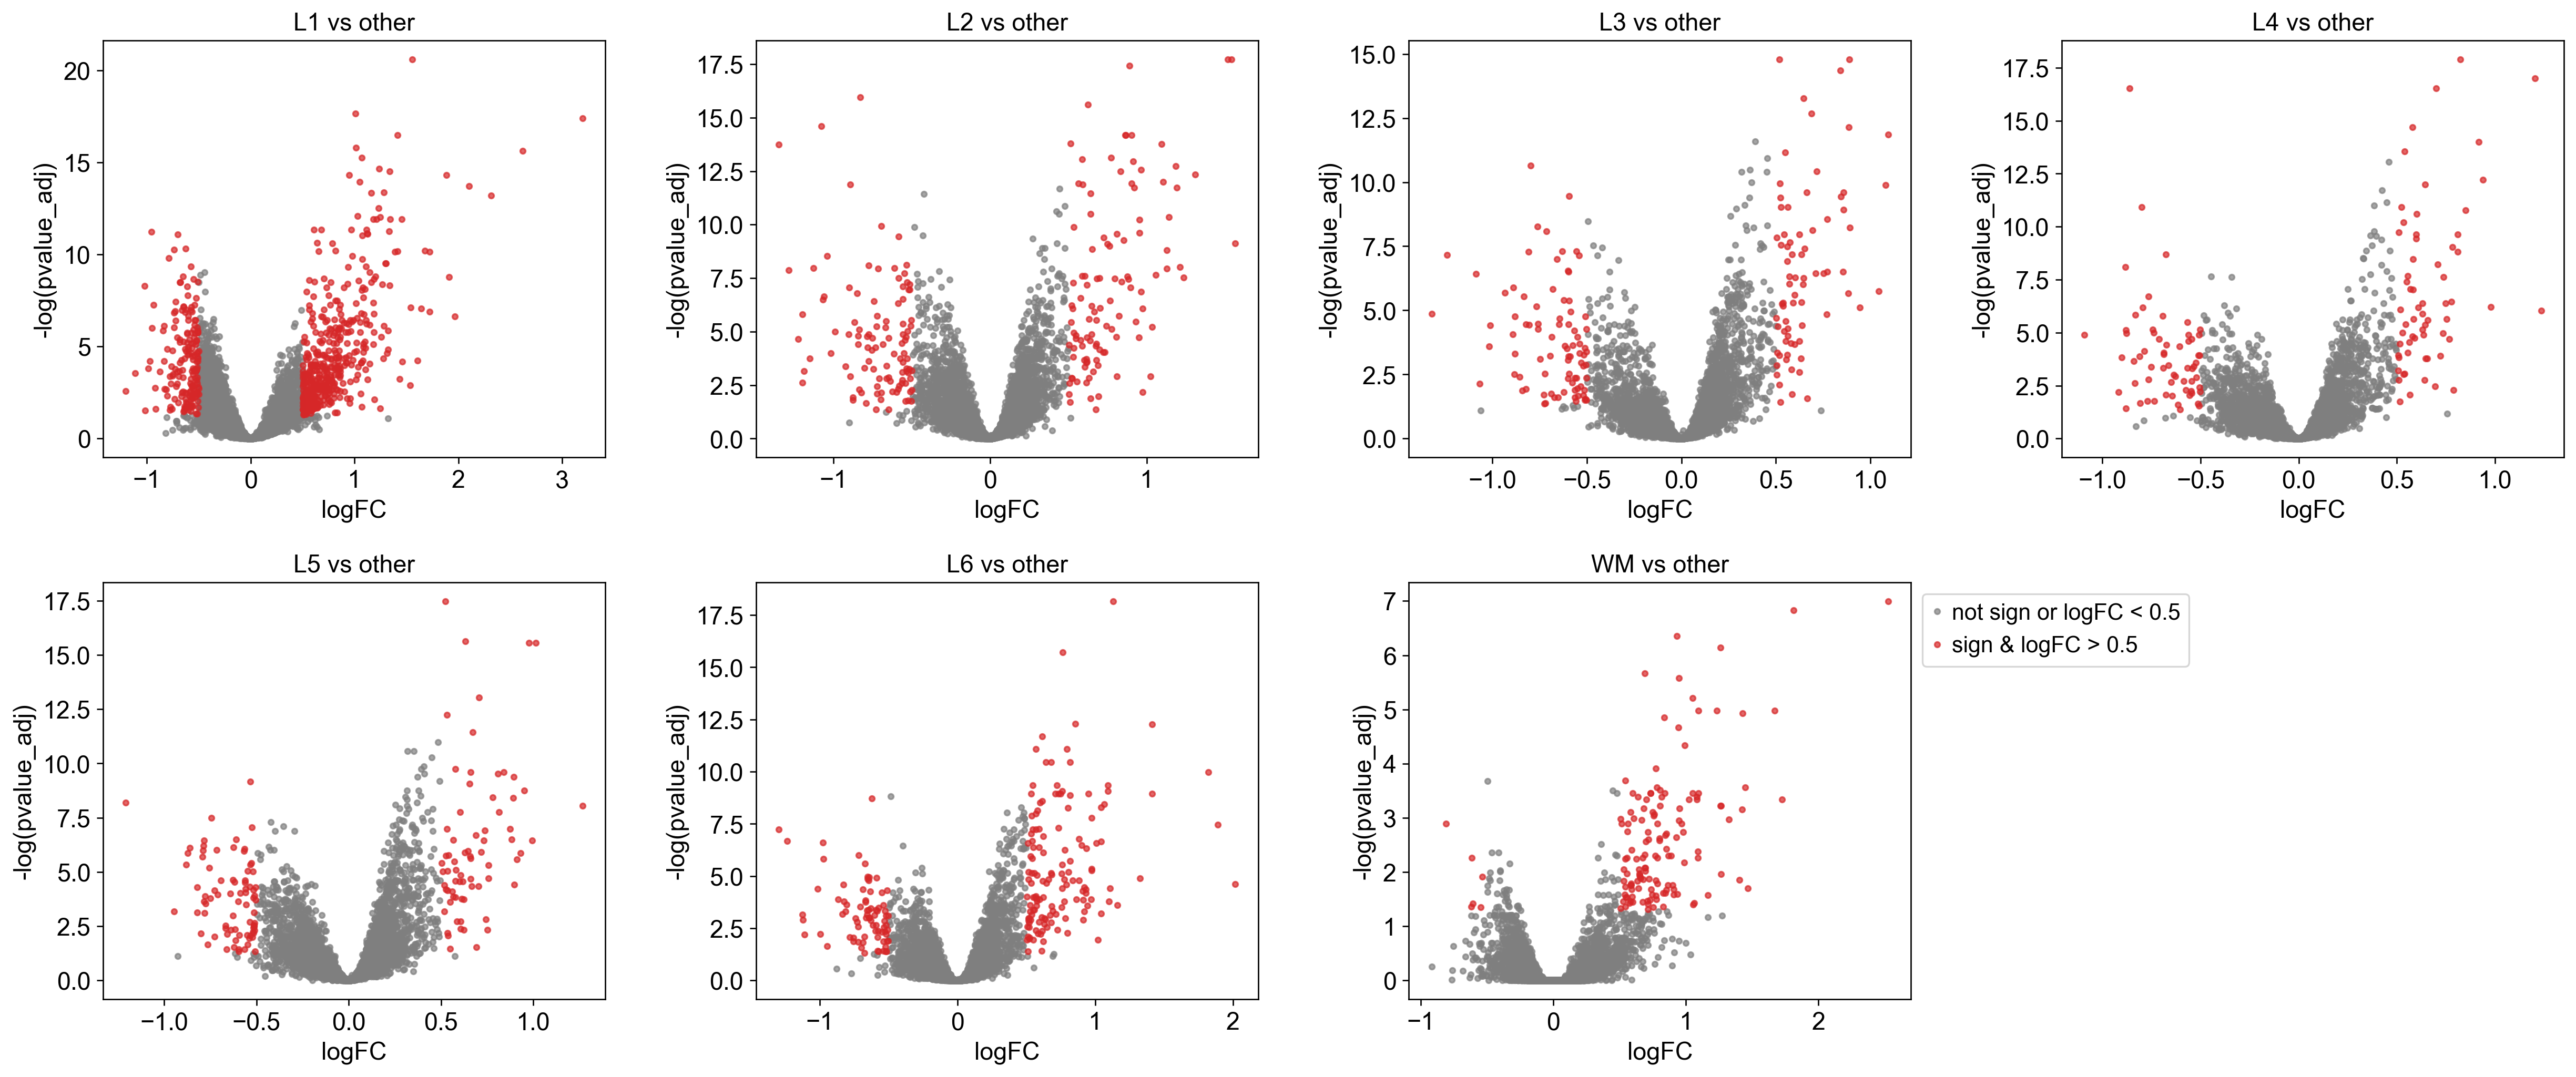

In [99]:
fig, axes = plt.subplots(2, 4,  figsize=(25, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, dpi=120)
#fig, ax = plt.subplots(1, 1,  figsize=(7, 5), gridspec_kw={'hspace': 0.5})

for (layer, df), ax in zip(human_de.items(), axes.flatten()):
    sign_tr = ((df.p_val_adj < 0.05) & (df.logFC > 1))
    filter_cond = ((df.p_val_adj < 0.05) & (df.logFC.abs() > 0.5))
    ax.plot(df[~filter_cond].logFC, -np.log10(df[~filter_cond].p_val_adj), '.', c='tab:gray', alpha=0.7)
    ax.plot(df[filter_cond].logFC, -np.log10(df[filter_cond].p_val_adj), '.', c='tab:red', alpha=0.7)
    ax.grid(False)
    ax.set_title(f'{layer} vs other')
    ax.set_ylabel('-log(pvalue_adj)')
    ax.set_xlabel('logFC')
    if layer == 'WM':
        ax.legend(['not sign or logFC < 0.5', 'sign & logFC > 0.5'], loc="upper left", bbox_to_anchor=(1,1))
fig.delaxes(axes[1, 3])

In [100]:
print("Summary for chimpanzee")
summary_de(chimp_de)

Summary for chimpanzee


L1    L2    L3    L4    L5    L6    WM
up_reg     615   305   558   609   317   149    95
not_sign  6688  7374  6996  6891  7399  7625  7674
down_reg   548   172   297   351   135    77    82

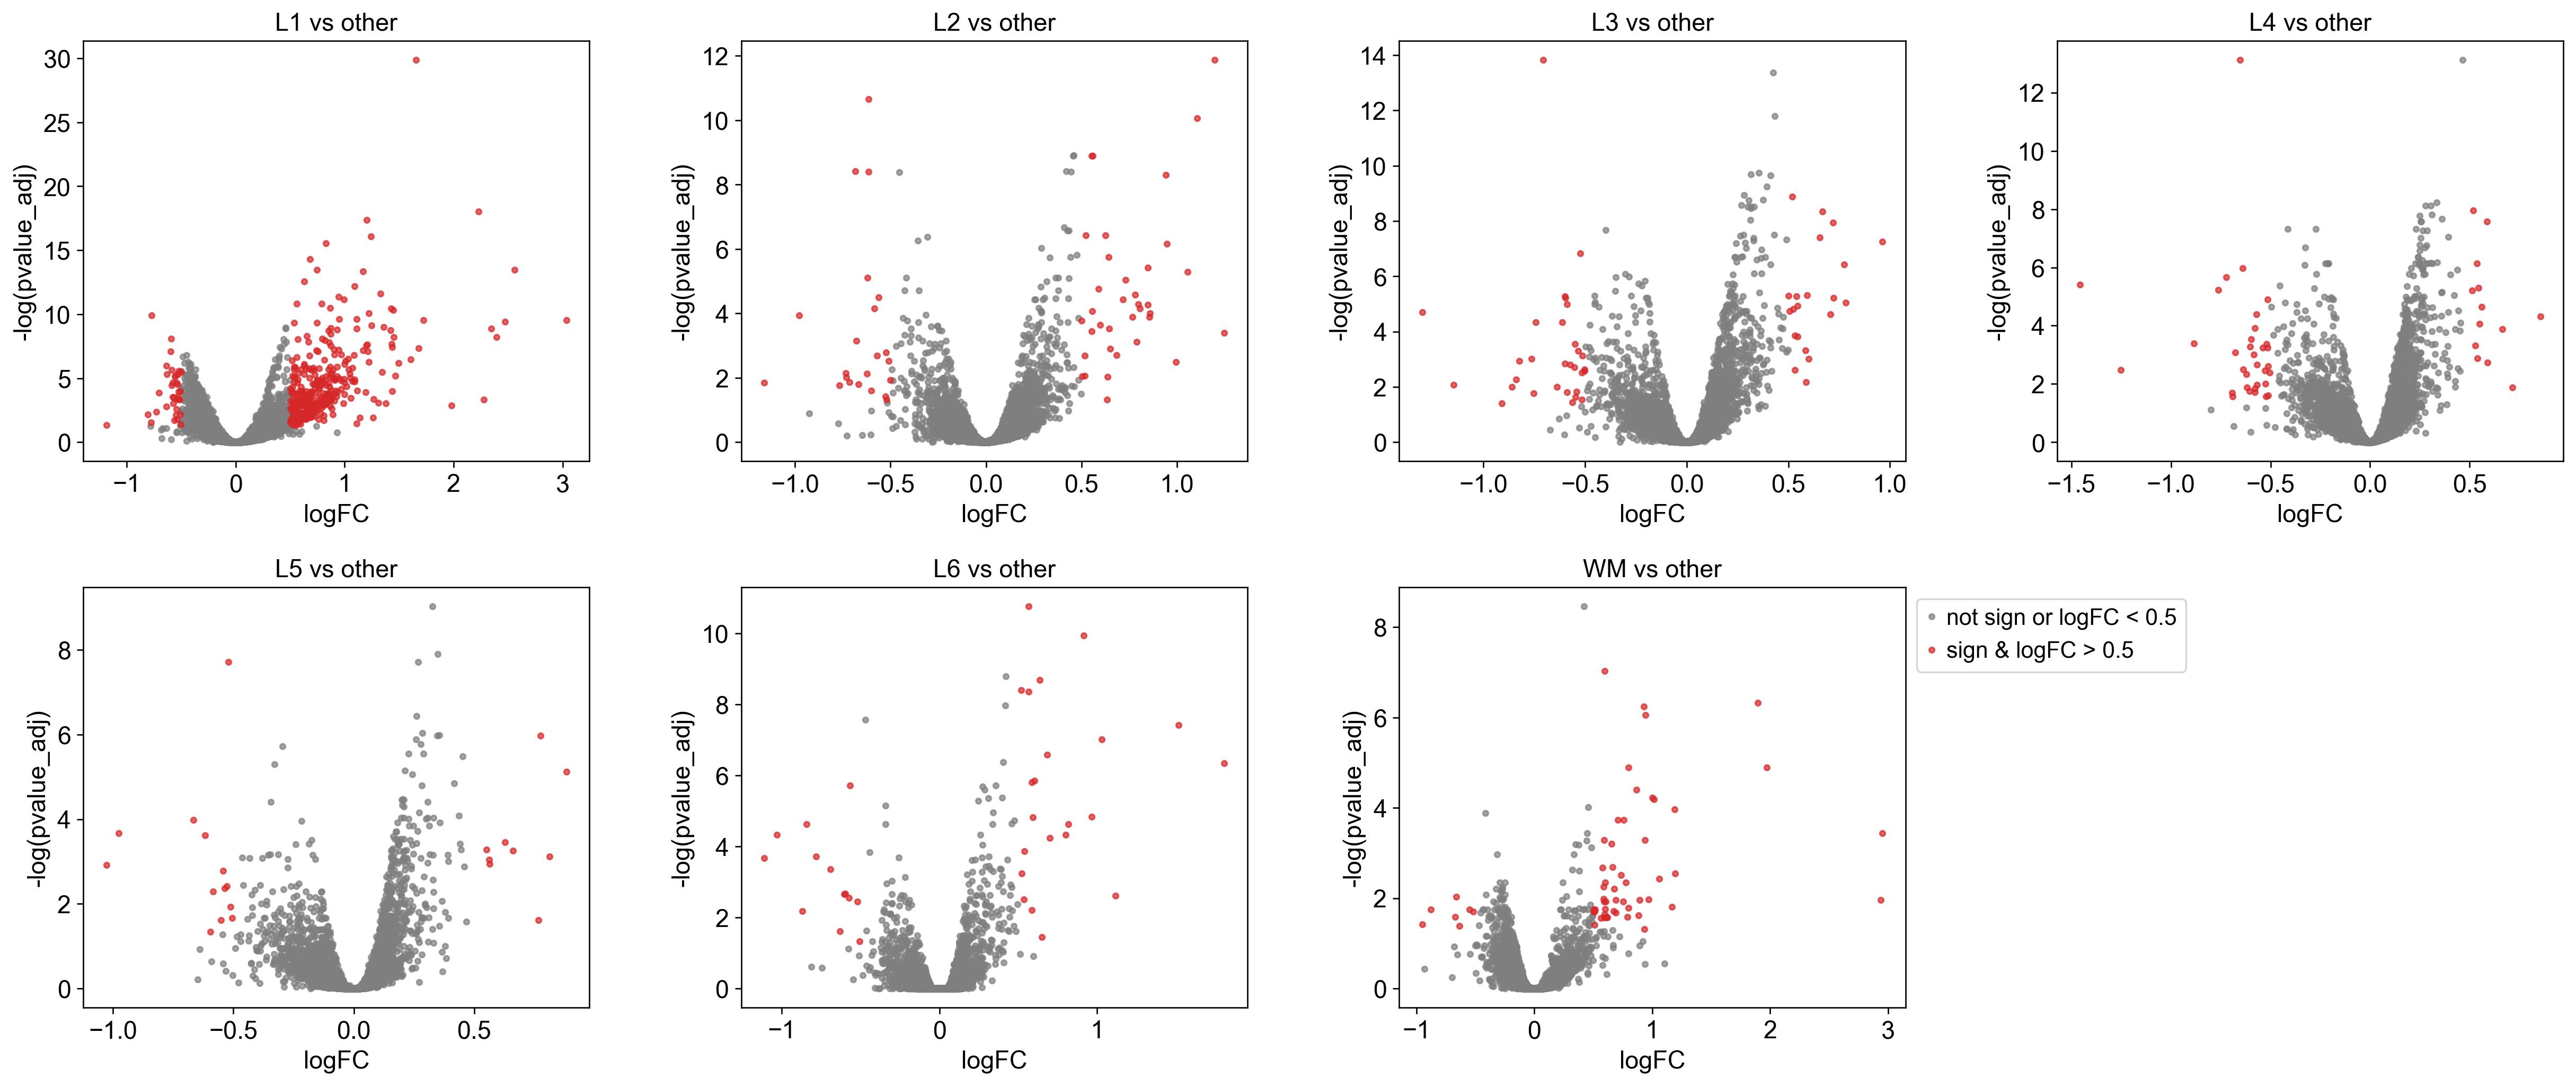

In [101]:
fig, axes = plt.subplots(2, 4,  figsize=(25, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, dpi=120)
#fig, ax = plt.subplots(1, 1,  figsize=(7, 5), gridspec_kw={'hspace': 0.5})

for (layer, df), ax in zip(chimp_de.items(), axes.flatten()):
    sign_tr = ((df.p_val_adj < 0.05) & (df.logFC > 1))
    filter_cond = ((df.p_val_adj < 0.05) & (df.logFC.abs() > 0.5))
    ax.plot(df[~filter_cond].logFC, -np.log10(df[~filter_cond].p_val_adj), '.', c='tab:gray', alpha=0.7)
    ax.plot(df[filter_cond].logFC, -np.log10(df[filter_cond].p_val_adj), '.', c='tab:red', alpha=0.7)
    ax.grid(False)
    ax.set_title(f'{layer} vs other')
    ax.set_ylabel('-log(pvalue_adj)')
    ax.set_xlabel('logFC')
    if layer == 'WM':
        ax.legend(['not sign or logFC < 0.5', 'sign & logFC > 0.5'], loc="upper left", bbox_to_anchor=(1,1))
fig.delaxes(axes[1, 3])

In [102]:
print("Summary for macaque")
summary_de(macaque_de)

Summary for macaque


L1    L2    L3    L4    L5    L6    WM
up_reg     781   706  1063   843   724   281  1208
not_sign  6363  6637  6179  6416  6571  7343  5213
down_reg   670   471   572   555   519   190  1393

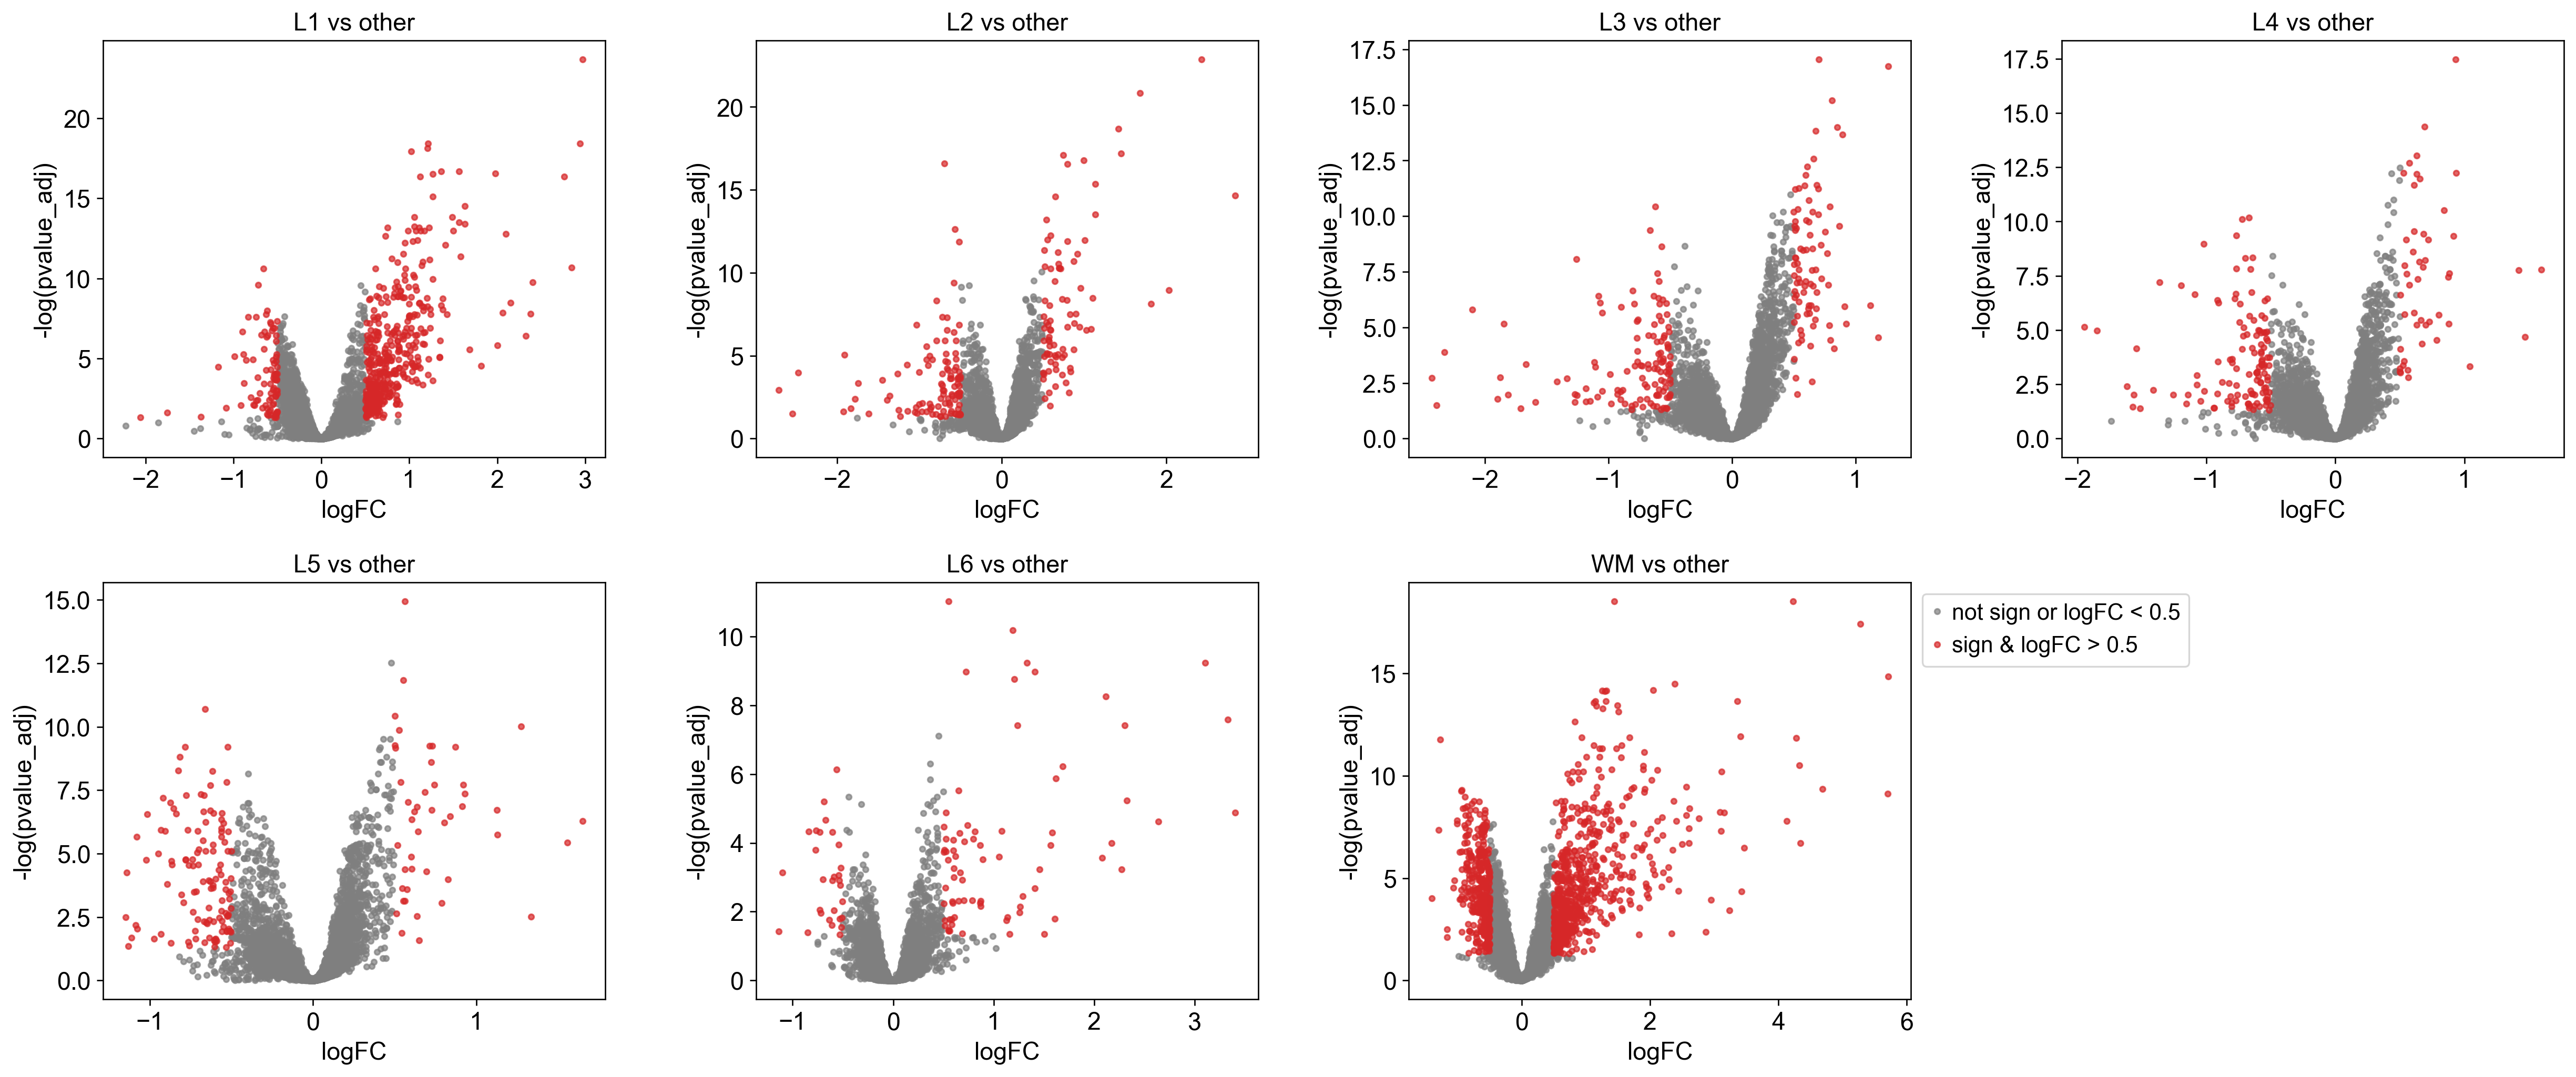

In [103]:
fig, axes = plt.subplots(2, 4,  figsize=(25, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, dpi=120)
#fig, ax = plt.subplots(1, 1,  figsize=(7, 5), gridspec_kw={'hspace': 0.5})

for (layer, df), ax in zip(macaque_de.items(), axes.flatten()):
    sign_tr = ((df.p_val_adj < 0.05) & (df.logFC > 1))
    filter_cond = ((df.p_val_adj < 0.05) & (df.logFC.abs() > 0.5))
    ax.plot(df[~filter_cond].logFC, -np.log10(df[~filter_cond].p_val_adj), '.', c='tab:gray', alpha=0.7)
    ax.plot(df[filter_cond].logFC, -np.log10(df[filter_cond].p_val_adj), '.', c='tab:red', alpha=0.7)
    ax.grid(False)
    ax.set_title(f'{layer} vs other')
    ax.set_ylabel('-log(pvalue_adj)')
    ax.set_xlabel('logFC')
    if layer == 'WM':
        ax.legend(['not sign or logFC < 0.5', 'sign & logFC > 0.5'], loc="upper left", bbox_to_anchor=(1,1))
fig.delaxes(axes[1, 3])

We can see that WM in macaque is considerably different from other layers

## Marker genes

Let's leave only upregulated marker genes

In [104]:
human_markers = {layer: df[(df.p_val_adj < 0.05) & (df.logFC > 0)].index for layer, df in human_de.items()}
chimp_markers = {layer: df[(df.p_val_adj < 0.05) & (df.logFC > 0)].index for layer, df in chimp_de.items()}
macaque_markers = {layer: df[(df.p_val_adj < 0.05) & (df.logFC > 0)].index for layer, df in macaque_de.items()}

### Human

Let's look at pca first

computing PCA
    with n_comps=34
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


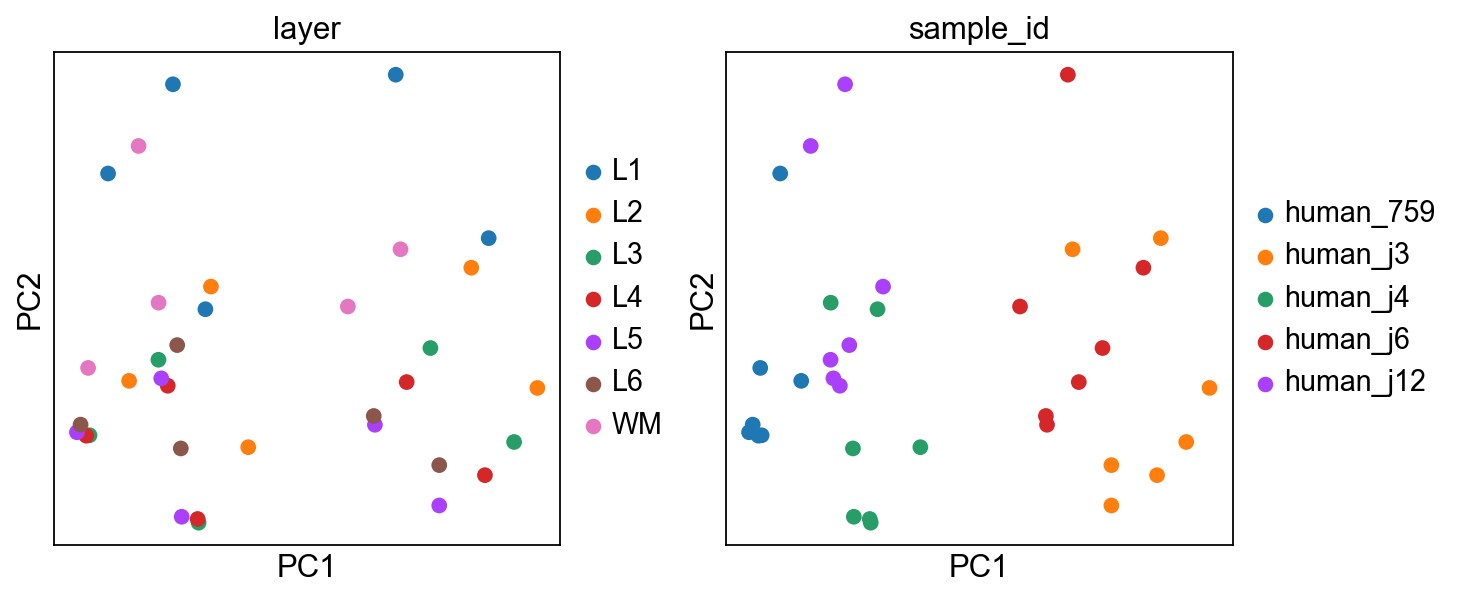

In [105]:
adata_subs = adata_pb[adata_pb.obs.condition == 'human', :].copy()
sc.pp.pca(adata_subs)
sc.pl.pca(adata_subs, color=['layer', 'sample_id'], size=200, show=True, ncols=2)

Let's leave only unique marker genes

In [106]:
import itertools

def count_unique(marker_dict):
    countgene_list = []
    unique_genes = dict()
    for layer in layers:
        layer_list = []
        for oth_lay in layers:
            if layer == oth_lay:
                marker_genes_other = list(itertools.chain(*[marker_dict[oth_lay] for oth_lay in layers if oth_lay != layer]))
                unique_genes[layer] = set(marker_dict[layer]).difference(marker_genes_other)
                layer_list.append(len(unique_genes[layer]))
            else:
                layer_list.append(len(set(marker_dict[layer]).intersection(marker_dict[oth_lay])))
        countgene_list.append(layer_list)

    countgene_df = pd.DataFrame(countgene_list, index=layers, columns=layers)
    return countgene_df, unique_genes

In [107]:
countgene_human_df, unique_human_genes = count_unique(human_markers)

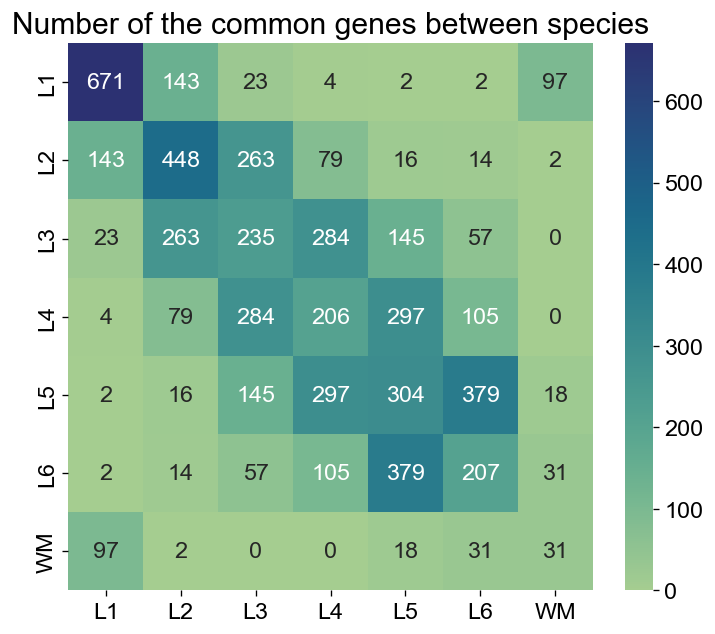

In [108]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(countgene_human_df, annot=True, cmap = 'crest', fmt=".0f")
plt.title('Number of the common genes between species', fontsize=18)
plt.grid(False)

Take top20 genes for each of the layers

In [109]:
top = 20
marker_top_list = []
for layer in layers:
    layer_topmarkers = human_de[layer].loc[list(unique_human_genes[layer])]['logFC'].sort_values(ascending=False).index.to_list()[:top]
    marker_top_list.append(layer_topmarkers)

marker_top_list = list(itertools.chain(*marker_top_list))

Plot the heatmap

d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


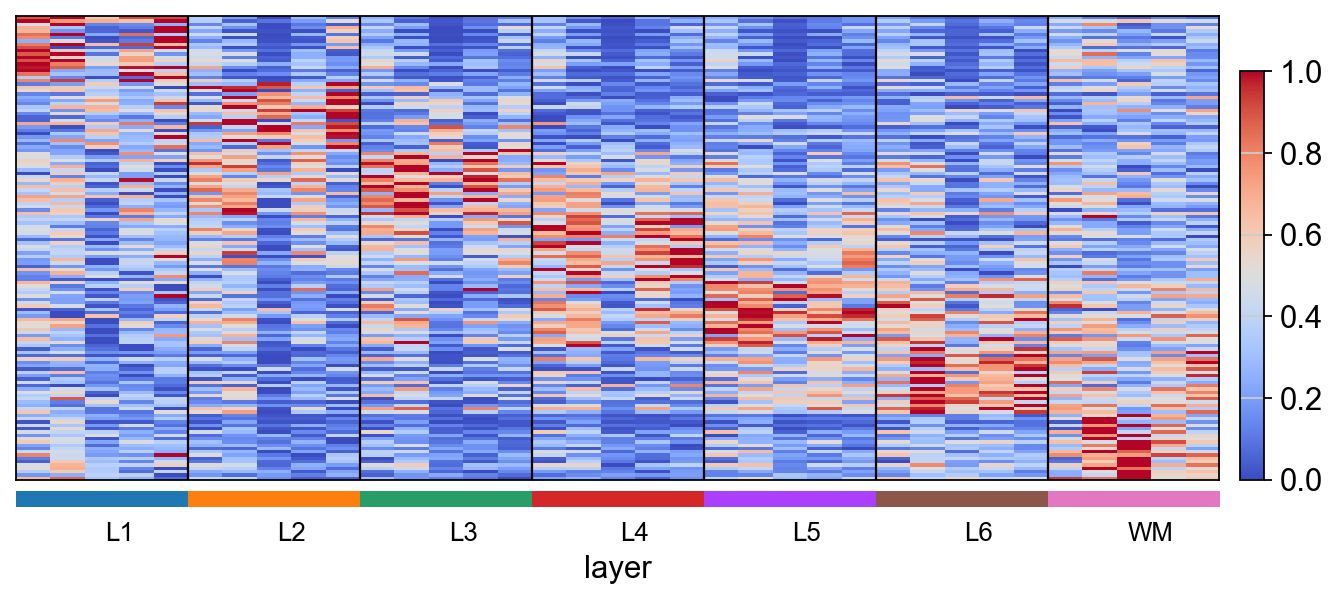

In [110]:
sc.pl.heatmap(adata_pb[adata_pb.obs.condition == 'human', :],
 marker_top_list, groupby='layer', swap_axes=True, standard_scale='var', cmap='coolwarm')

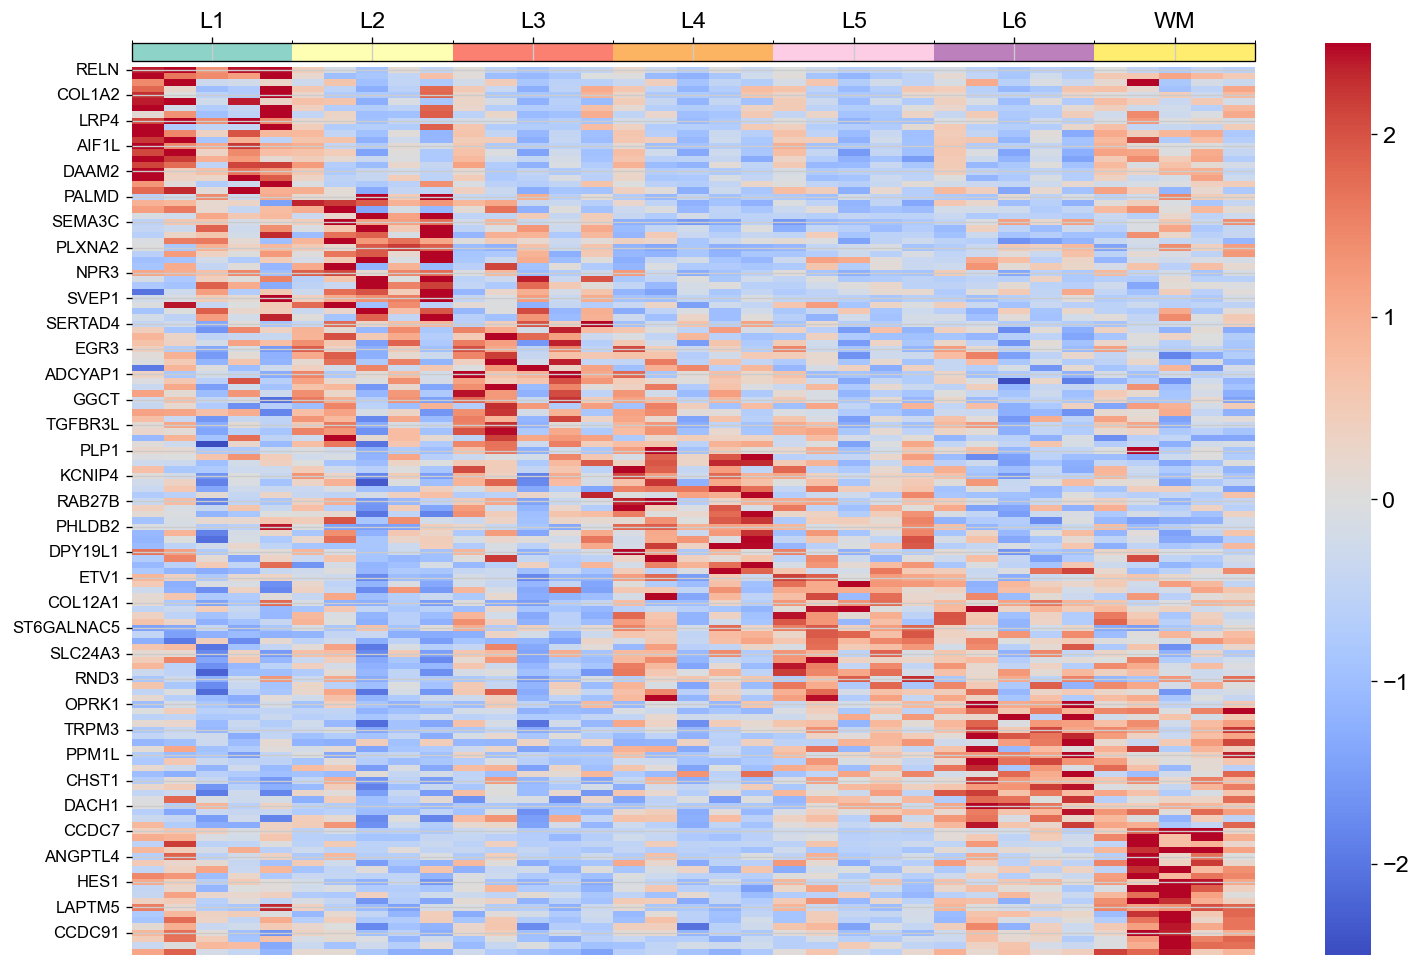

In [111]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'human', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

### Chimp

Let's look at pca plot

computing PCA
    with n_comps=30
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


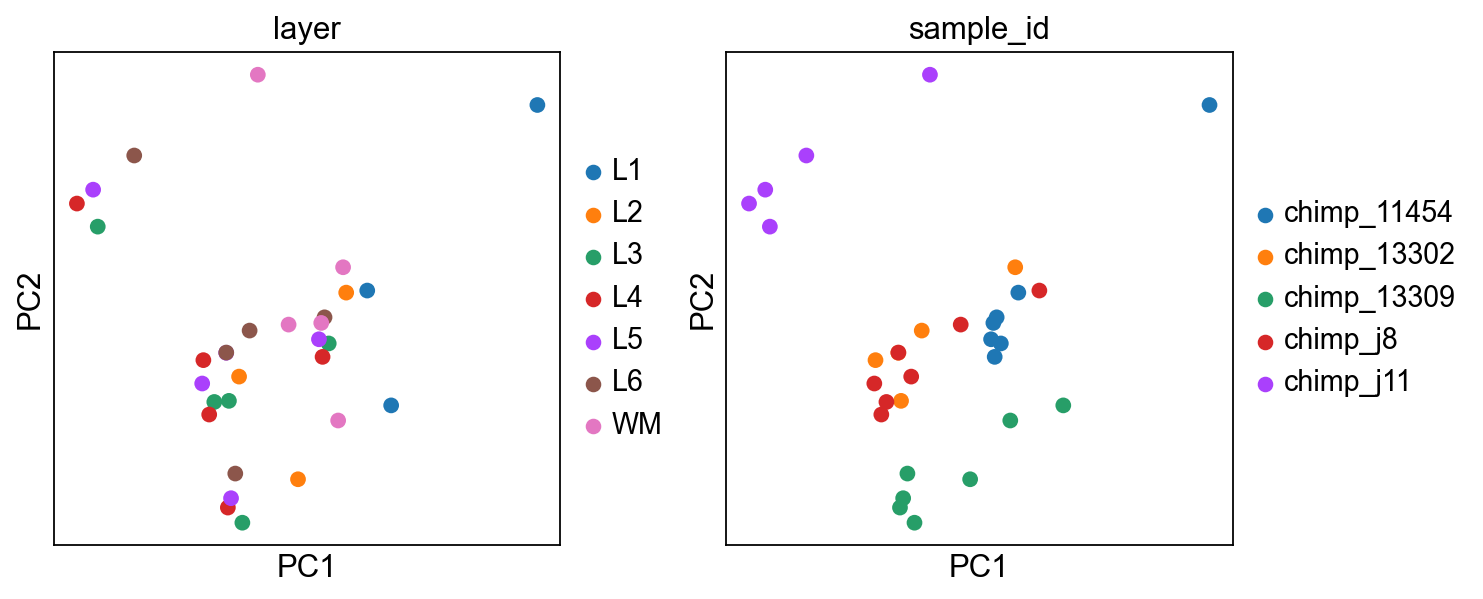

In [112]:
adata_subs = adata_pb[adata_pb.obs.condition == 'chimp', :].copy()
sc.pp.pca(adata_subs)
sc.pl.pca(adata_subs, color=['layer', 'sample_id'], size=200, show=True, ncols=2)

Let's leave only unique marker genes

In [113]:
countgene_chimp_df, unique_chimp_genes = count_unique(chimp_markers)

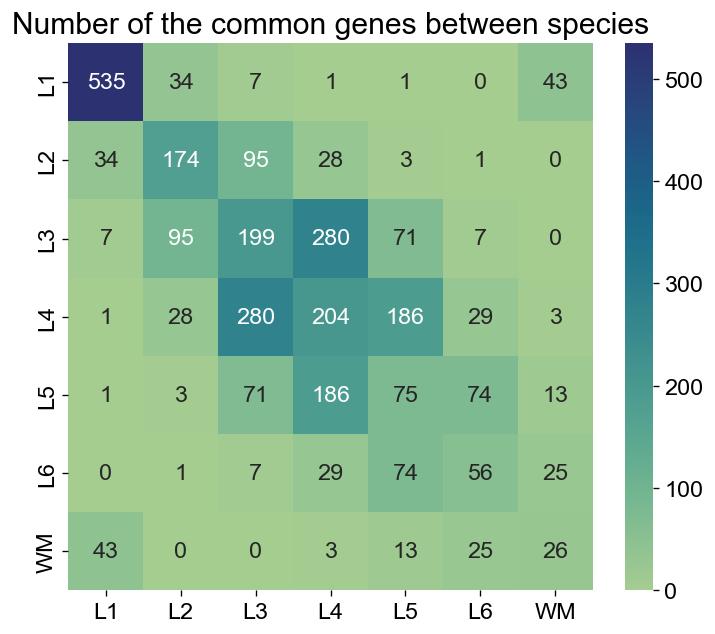

In [114]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(countgene_chimp_df, annot=True, cmap = 'crest', fmt=".0f")
plt.title('Number of the common genes between species', fontsize=18)
plt.grid(False)

Take top20 genes for each of the layers

In [115]:
top = 20
marker_top_list = []
for layer in layers:
    layer_topmarkers = chimp_de[layer].loc[list(unique_chimp_genes[layer])]['logFC'].sort_values(ascending=False).index.to_list()[:top]
    marker_top_list.append(layer_topmarkers)

marker_top_list = list(itertools.chain(*marker_top_list))

Plot the heatmap

d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


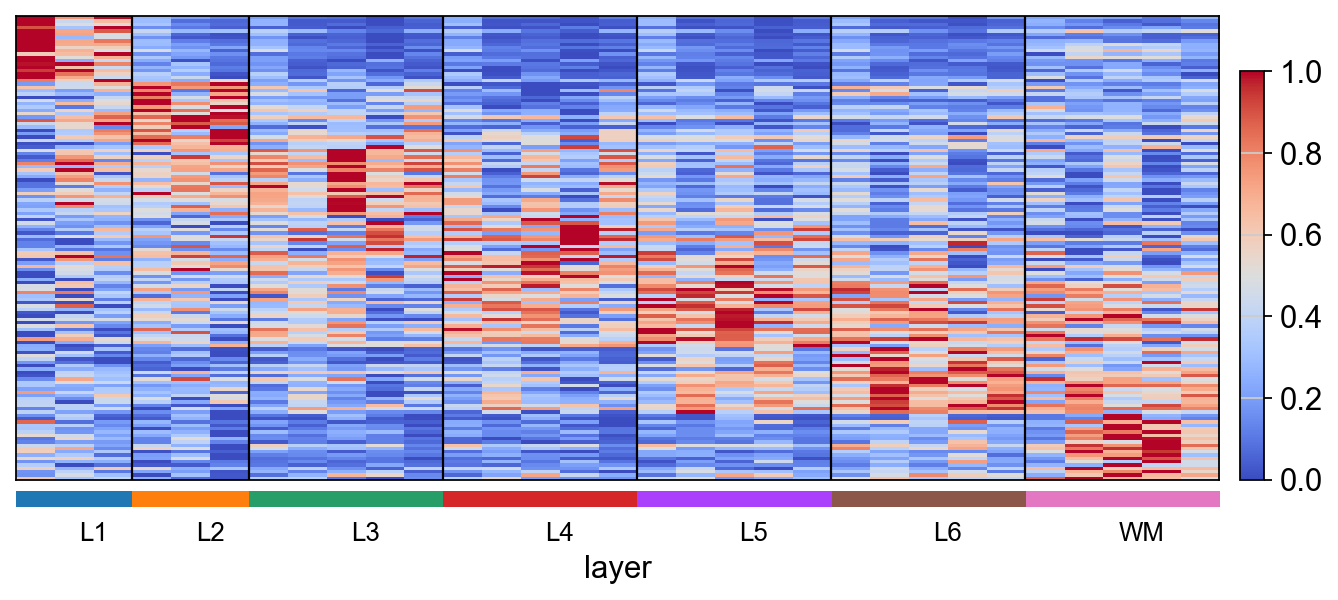

In [116]:
sc.pl.heatmap(adata_pb[adata_pb.obs.condition == 'chimp', :],
 marker_top_list, groupby='layer', swap_axes=True, standard_scale='var', cmap='coolwarm')

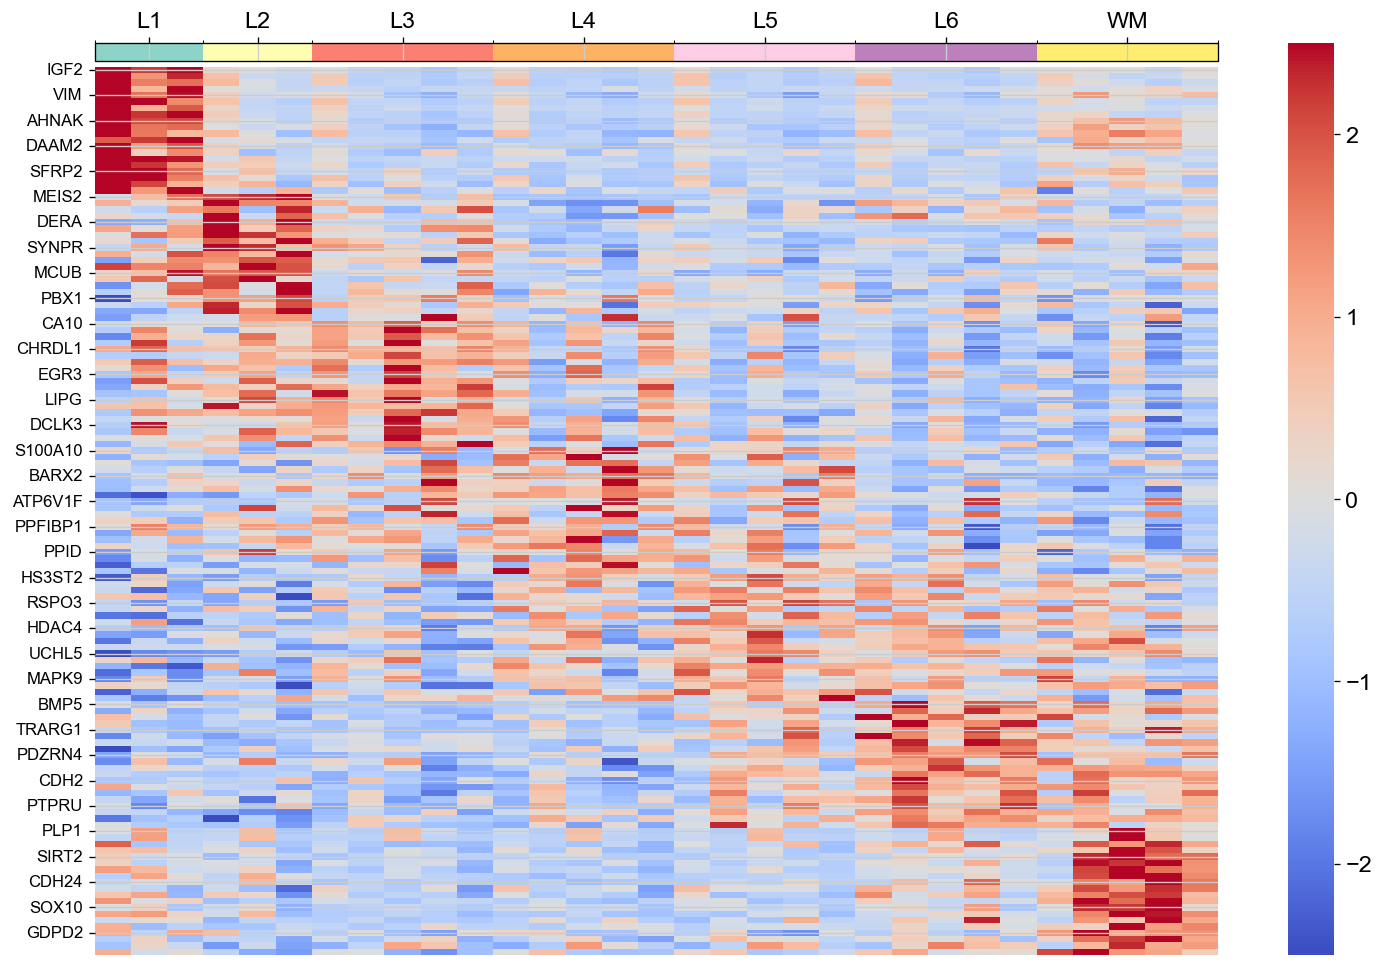

In [117]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'chimp', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

### Macaque

Let's look at PCA plot first

computing PCA
    with n_comps=27
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


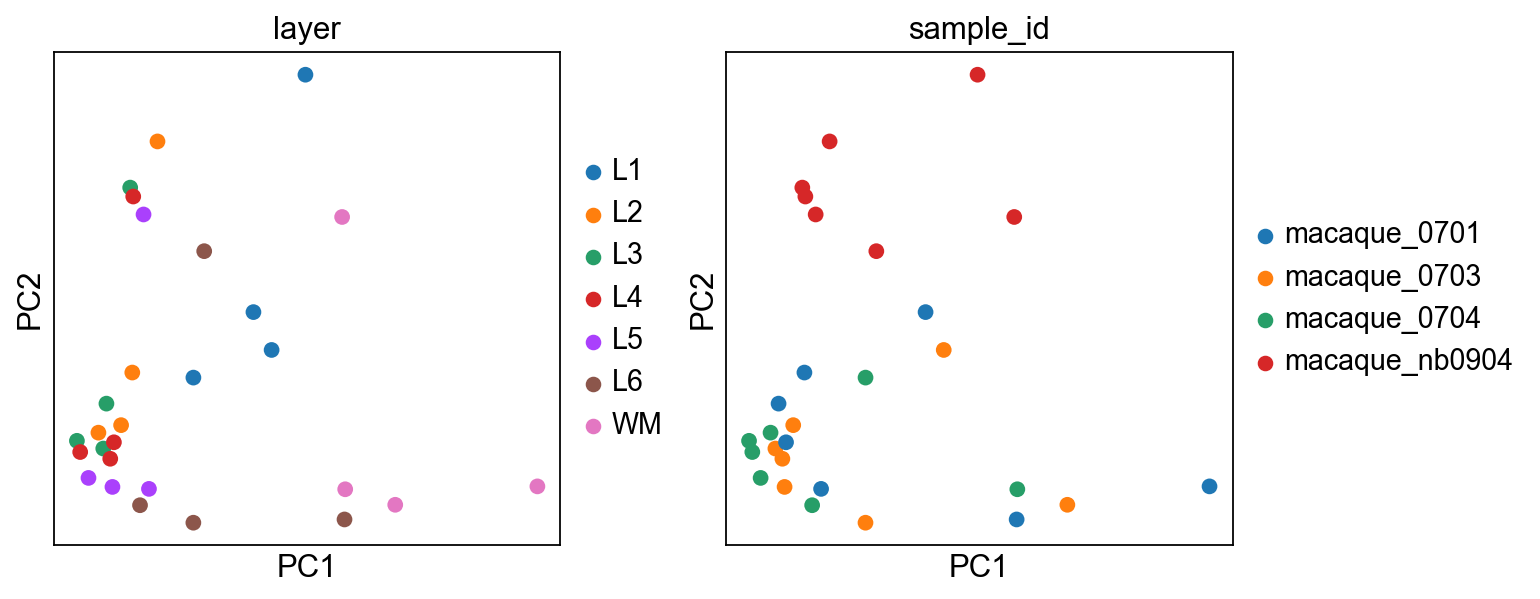

In [118]:
adata_subs = adata_pb[adata_pb.obs.condition == 'macaque', :].copy()
sc.pp.pca(adata_subs)
sc.pl.pca(adata_subs, color=['layer', 'sample_id'], size=200, show=True, ncols=2)

Let's leave only unique marker genes

In [119]:
countgene_macaque_df, unique_macaque_genes = count_unique(macaque_markers)

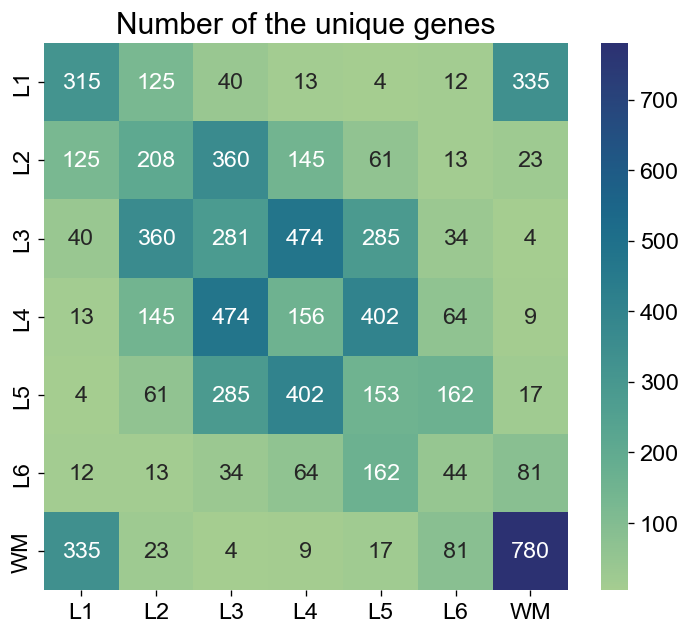

In [120]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(countgene_macaque_df, annot=True, cmap = 'crest', fmt=".0f")
plt.title('Number of the unique genes', fontsize=18)
plt.grid(False)

Take top20 genes for each of the layers

In [121]:
top = 20
marker_top_list = []
for layer in layers:
    layer_topmarkers = macaque_de[layer].loc[list(unique_macaque_genes[layer])]['logFC'].sort_values(ascending=False).index.to_list()[:top]
    marker_top_list.append(layer_topmarkers)

marker_top_list = list(itertools.chain(*marker_top_list))

Plot the heatmap

d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


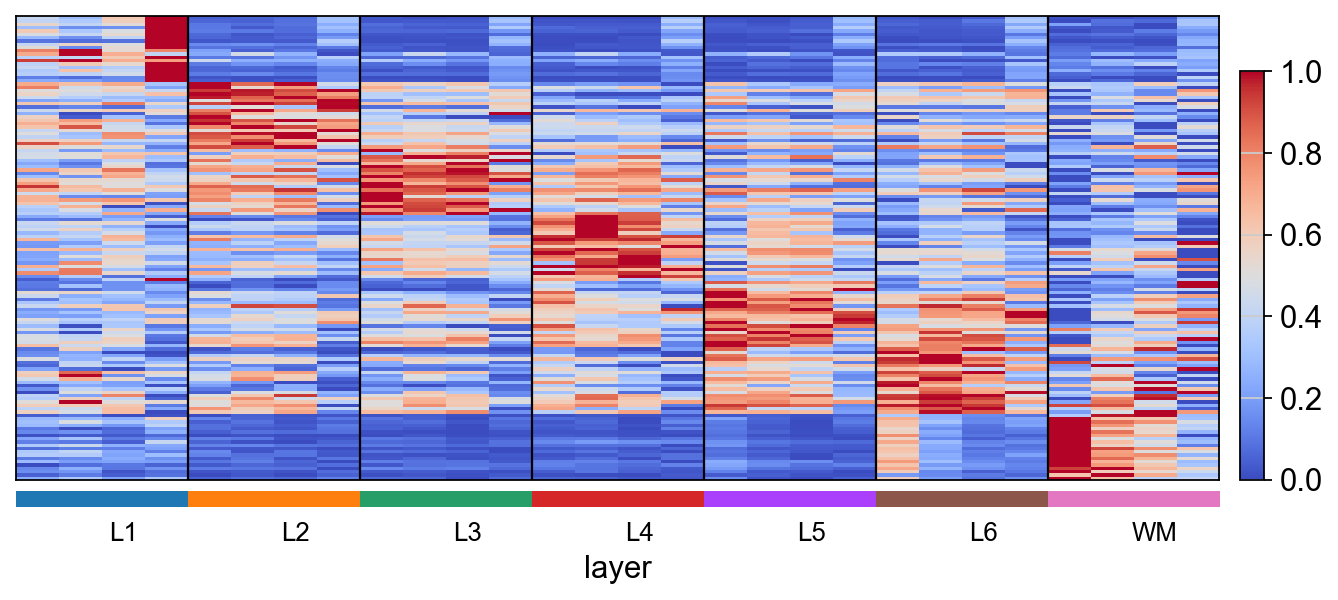

In [122]:
sc.pl.heatmap(adata_pb[adata_pb.obs.condition == 'macaque', :],
 marker_top_list, groupby='layer', swap_axes=True, standard_scale='var', cmap='coolwarm')

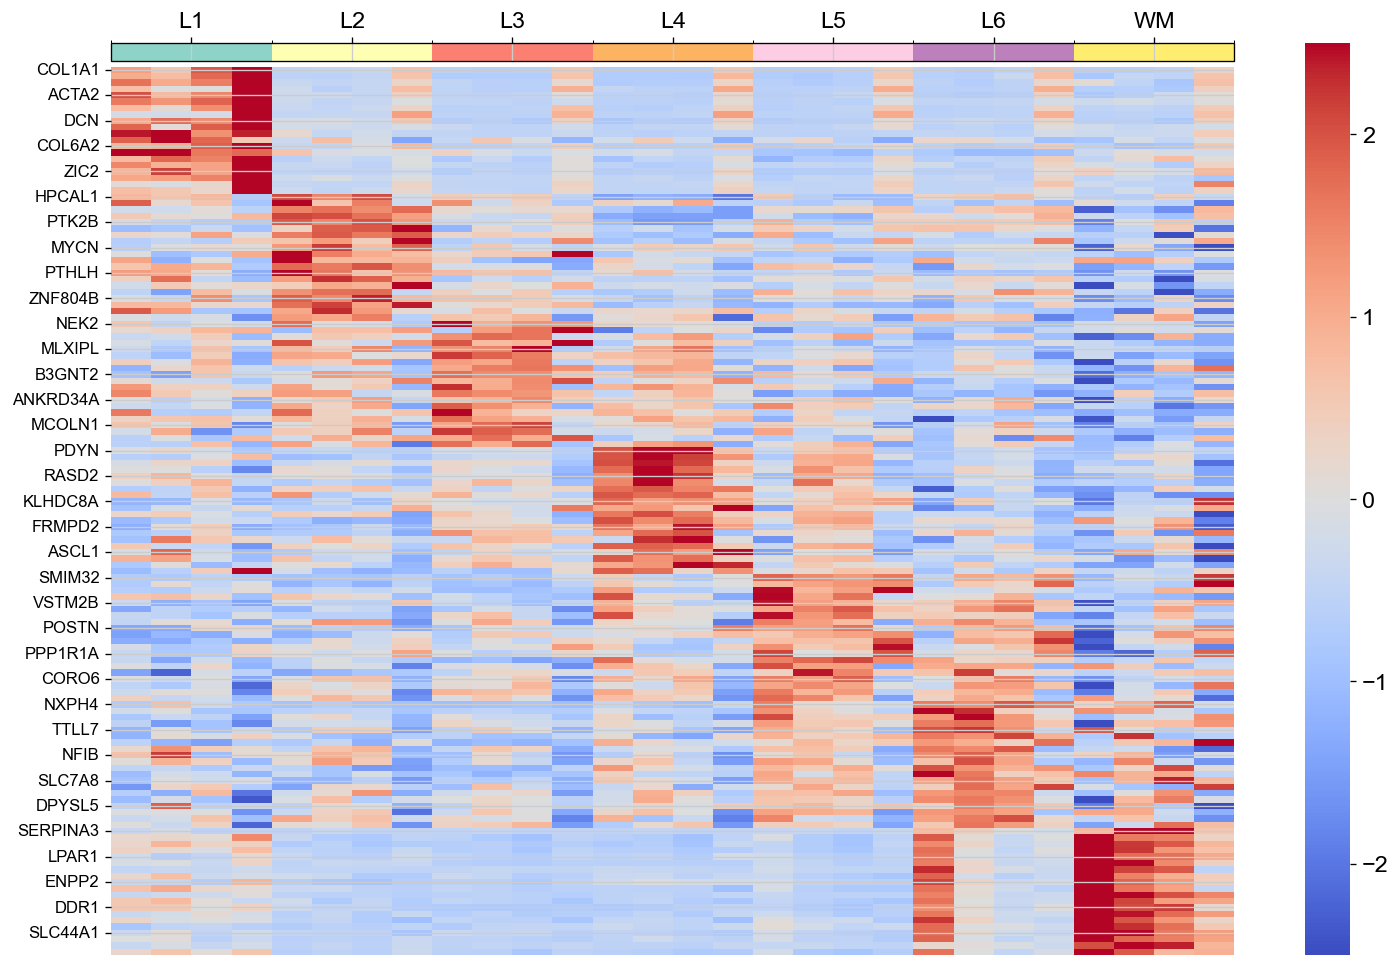

In [123]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'macaque', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

## Universal marker genes

### Common marker genes

Let's intersect marker genes for different species

In [126]:
marker_genes = dict()

for layer in layers:
    marker_genes[layer] = human_markers[layer].intersection(chimp_markers[layer]).intersection(macaque_markers[layer]).to_list()
    print(f'{layer}: {len(marker_genes[layer])} common marker genes')

L1: 252 common marker genes
L2: 52 common marker genes
L3: 138 common marker genes
L4: 132 common marker genes
L5: 133 common marker genes
L6: 38 common marker genes
WM: 30 common marker genes


Take top20 genes for each of the layers

In [154]:
top = 20
marker_top_list = []
for layer in layers:
    human_rk = human_de[layer].logFC.rank().loc[marker_genes[layer]]
    chimp_rk = chimp_de[layer].logFC.rank().loc[marker_genes[layer]]
    macaque_rk = macaque_de[layer].logFC.rank().loc[marker_genes[layer]]
    layer_topmarkers = (human_rk + chimp_rk + macaque_rk).sort_values(ascending=False).index.to_list()[:top]
    marker_top_list.append(layer_topmarkers)

marker_top_list = list(itertools.chain(*marker_top_list))

Plot the heatmap

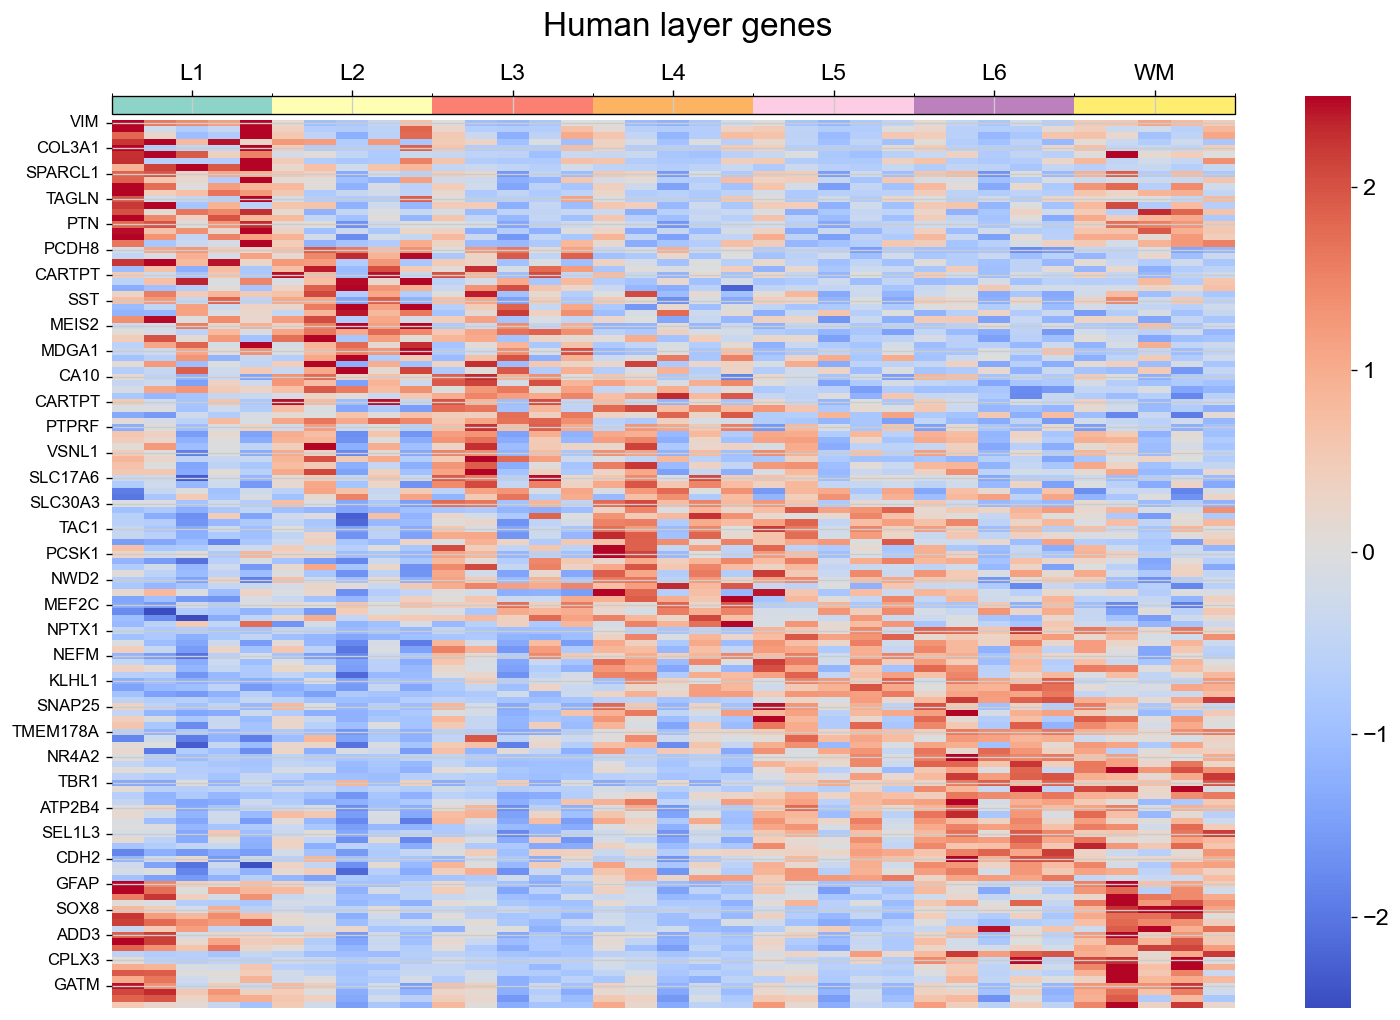

In [162]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'human', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.suptitle('Human layer genes', fontsize=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

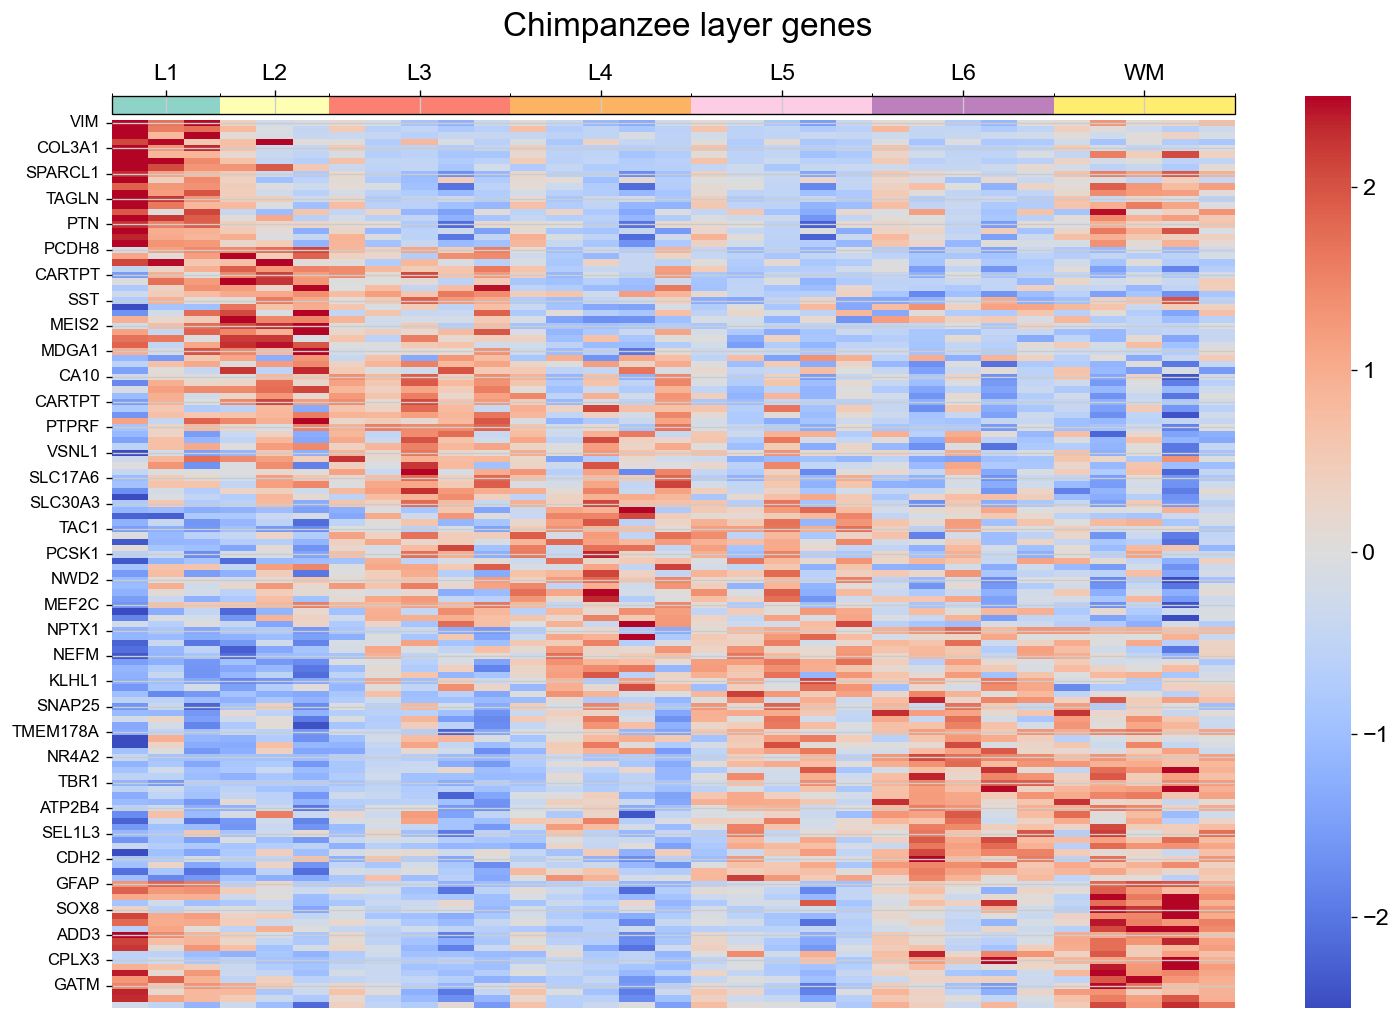

In [163]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'chimp', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.suptitle('Chimpanzee layer genes', fontsize=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

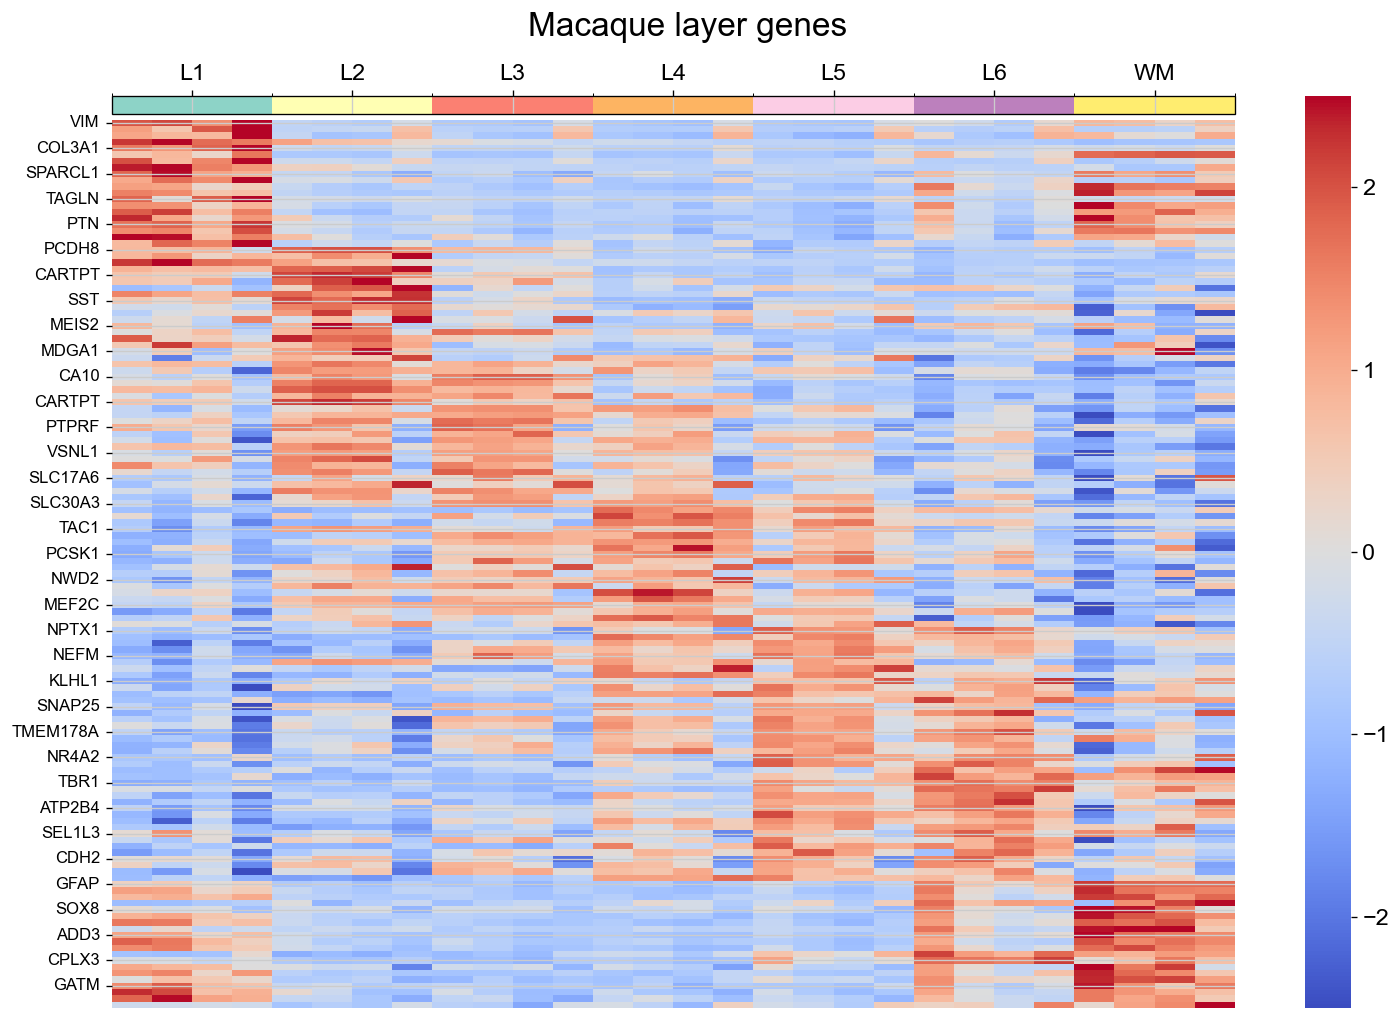

In [164]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'macaque', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.suptitle('Macaque layer genes', fontsize=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

### Common unique marker genes

Let's count number of unique marker genes

In [165]:
countgene_species_df, unique_species_genes = count_unique(marker_genes)

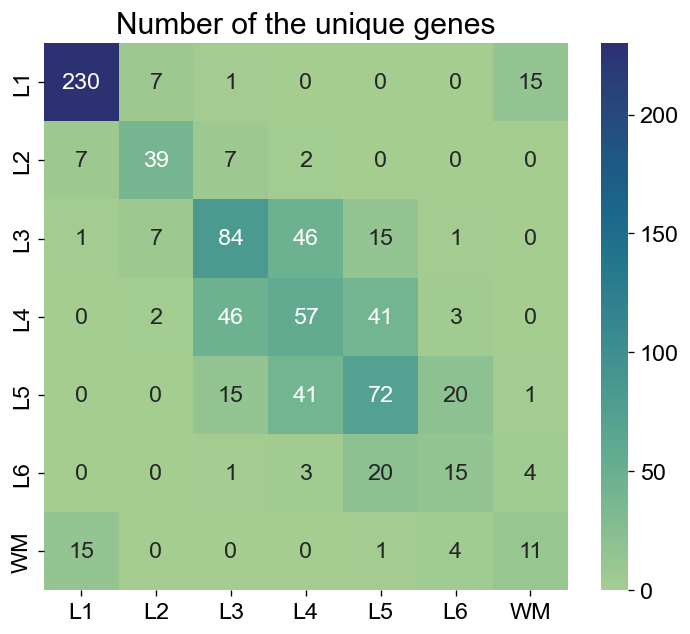

In [166]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(countgene_species_df, annot=True, cmap = 'crest', fmt=".0f")
plt.title('Number of the unique genes', fontsize=18)
plt.grid(False)

Take top20 genes for each of the layers

In [174]:
top = 20
marker_top_list = []
for layer in layers:
    slice_top = min(top, len(unique_species_genes[layer]))
    human_rk = human_de[layer].logFC.rank().loc[list(unique_species_genes[layer])]
    chimp_rk = chimp_de[layer].logFC.rank().loc[list(unique_species_genes[layer])]
    macaque_rk = macaque_de[layer].logFC.rank().loc[list(unique_species_genes[layer])]
    layer_topmarkers = (human_rk + chimp_rk + macaque_rk).sort_values(ascending=False).index.to_list()[:top]
    marker_top_list.append(layer_topmarkers)

marker_top_list = list(itertools.chain(*marker_top_list))

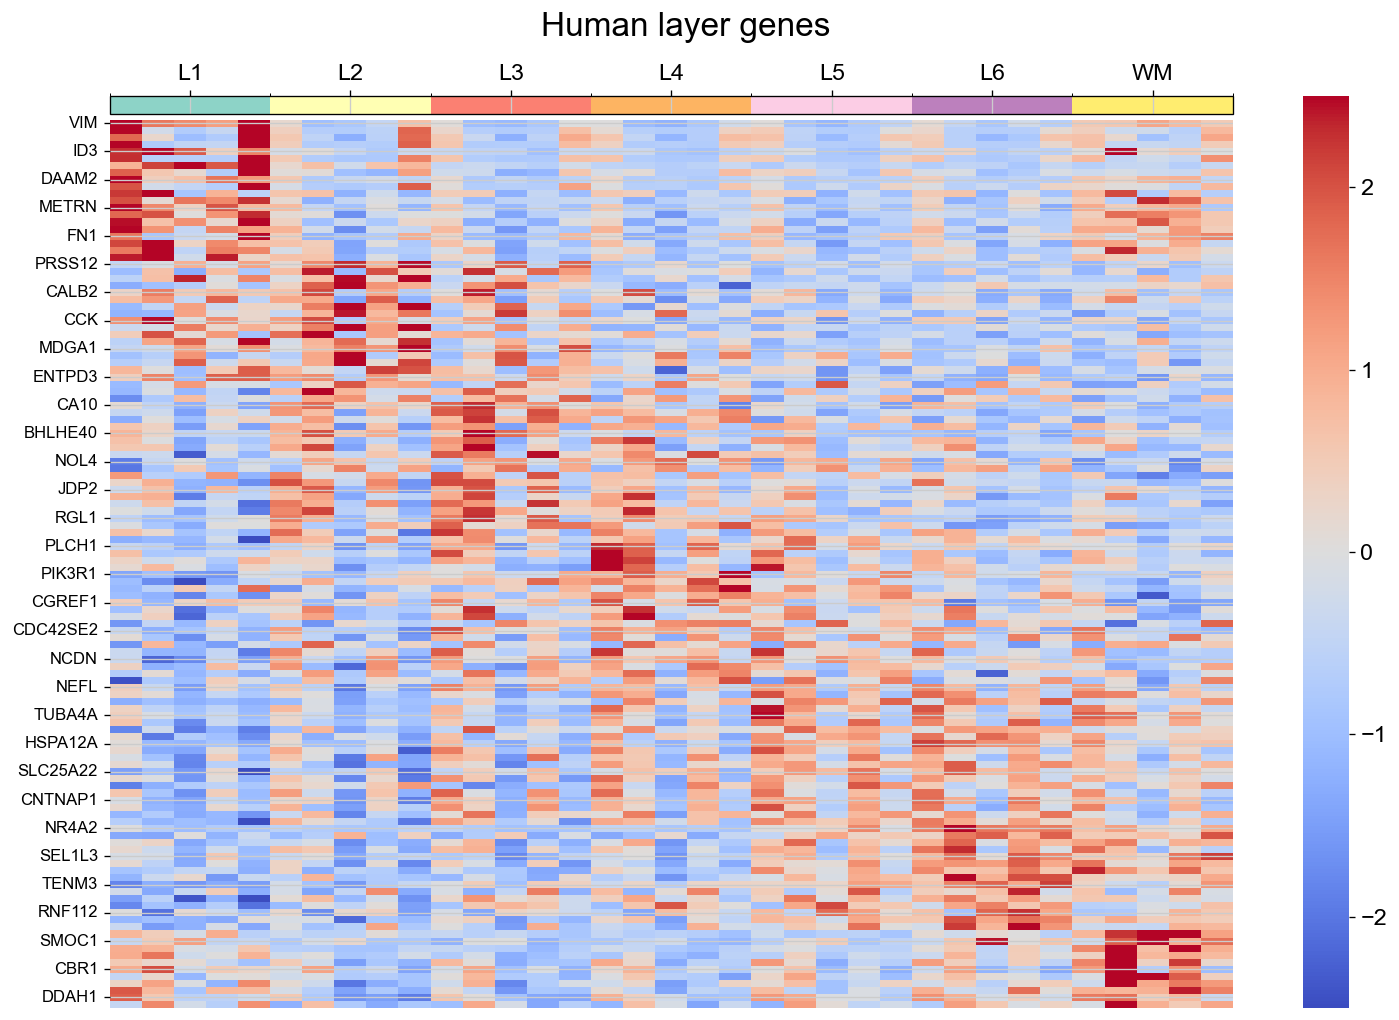

In [175]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'human', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.suptitle('Human layer genes', fontsize=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

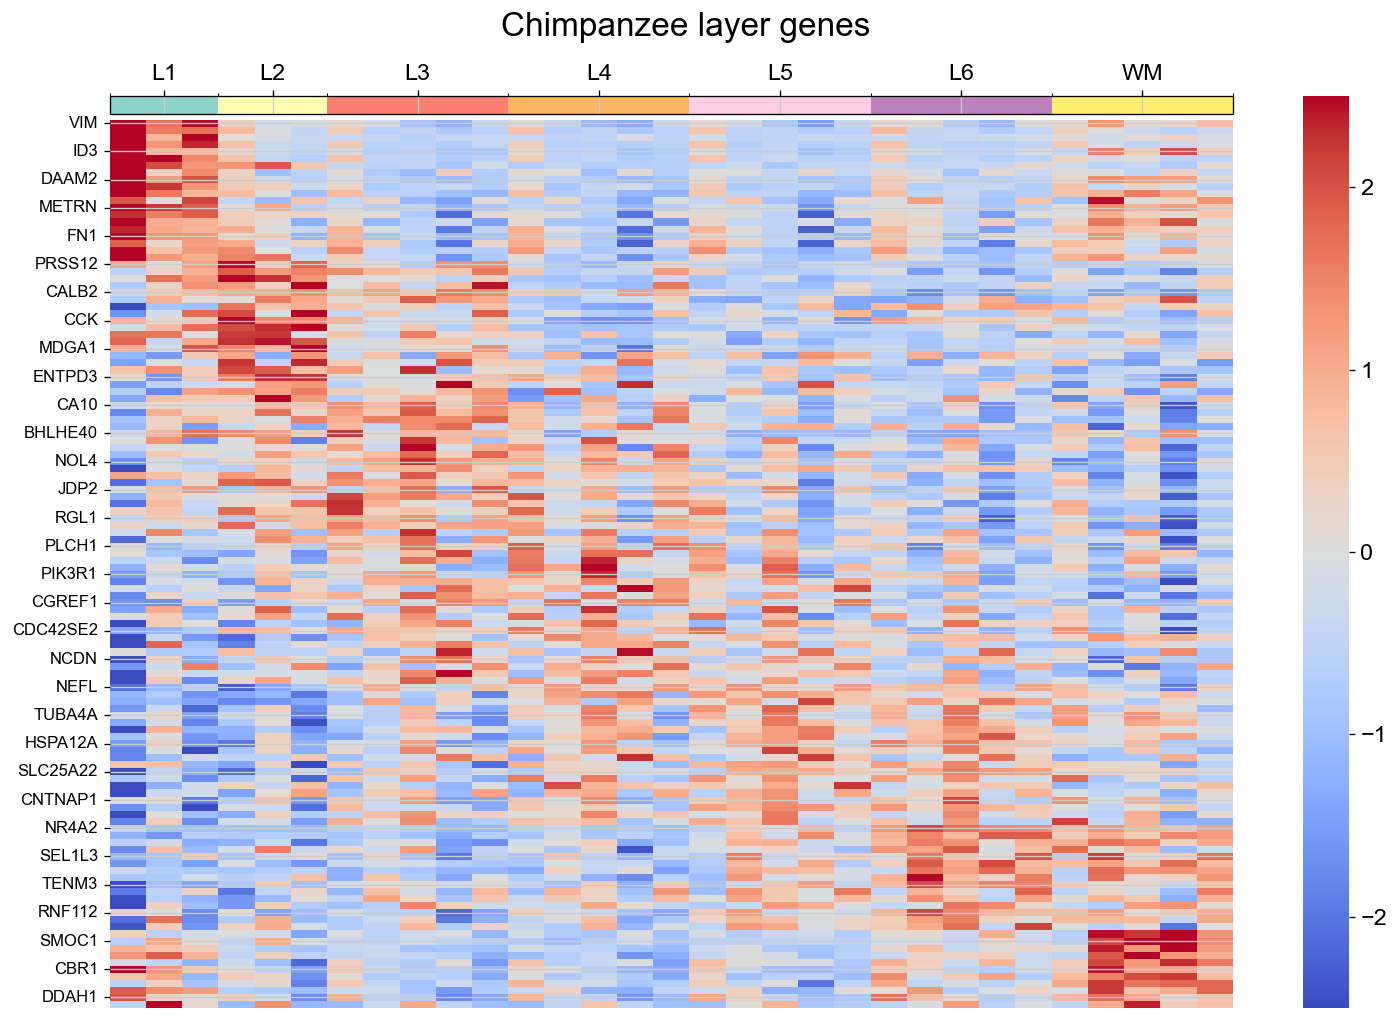

In [176]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'chimp', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.suptitle('Chimpanzee layer genes', fontsize=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

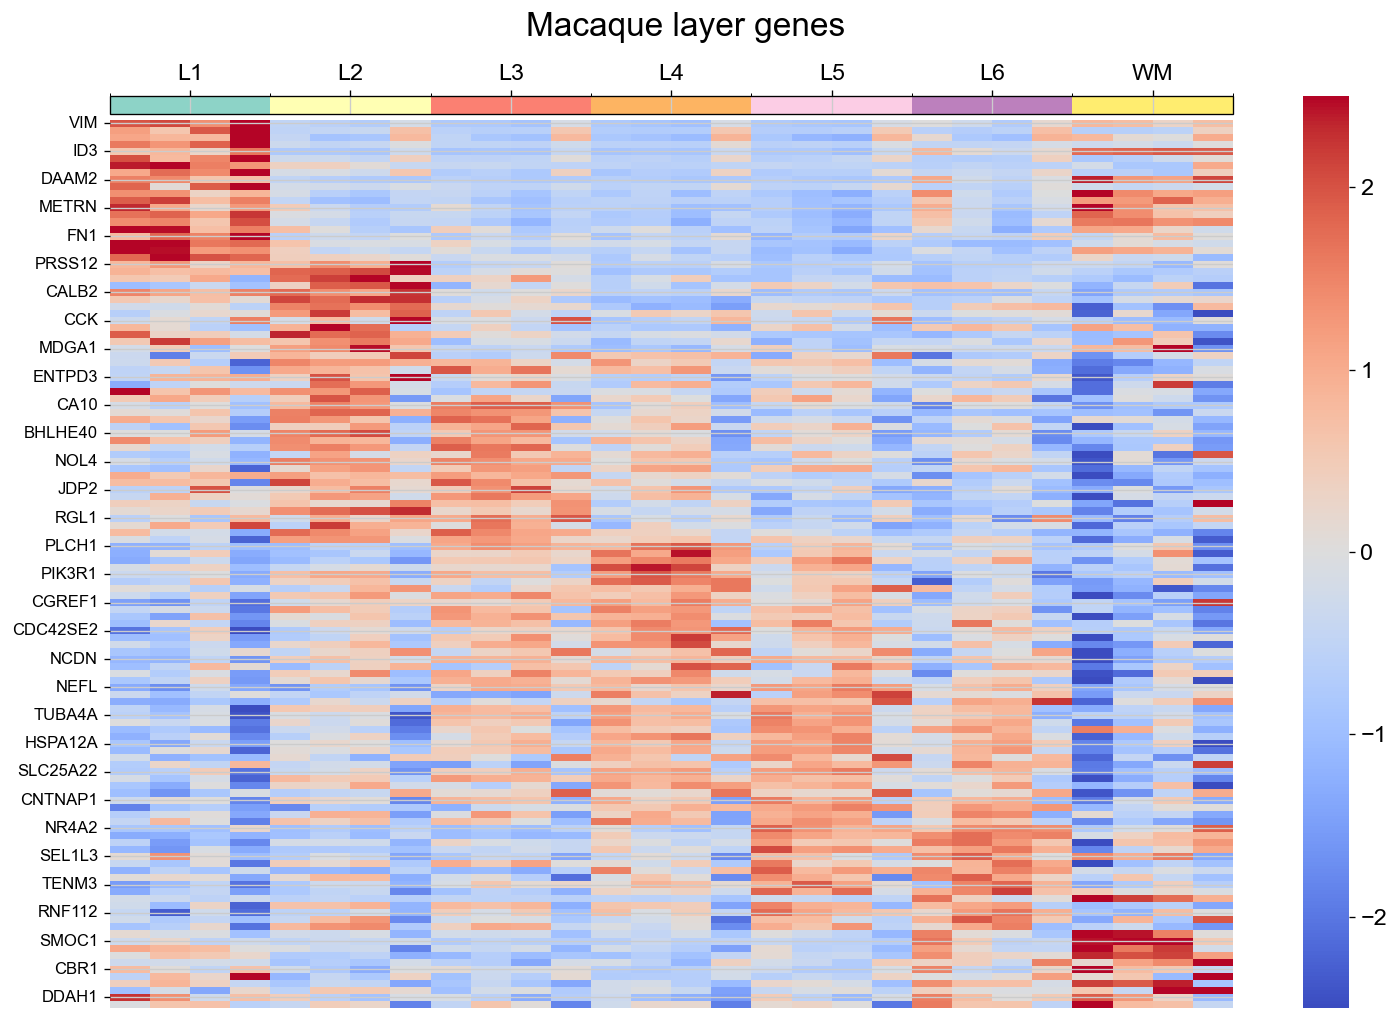

In [177]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'macaque', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.suptitle('Macaque layer genes', fontsize=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()